# Amazon Fine Food Review- Using XGboost And Random Forest

In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from scipy.stats import uniform
import warnings
import graphviz
from sklearn.tree import export_graphviz

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import sqlite3
con = sqlite3.connect("finalassignment.sqlite")

In [4]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [5]:
cleaned_data.shape

(364171, 12)

In [6]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")
#cleaned_data.head()

In [7]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
final = cleaned_data.iloc[:10000,:]
final.shape

(10000, 12)

In [9]:
# converting scores in 0 and 1
final["Score"] = final["Score"].apply(lambda x: 1 if x == "positive" else 0)

# Bag of Word

In [10]:
def optimal_tree_xgb(X_train, y_train):
    
    param = {"max_depth": list(range(3, 20, 3)), "n_estimators": list(range(3, 20, 3))}
    cv = TimeSeriesSplit(n_splits = 3)
    xgb_grid = GridSearchCV(XGBClassifier(), param_grid = param, cv = cv, scoring = "roc_auc")
    xgb_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nBest depth:", xgb_grid.best_estimator_.max_depth)
    print("\nBest estimator:", xgb_grid.best_estimator_.n_estimators)
    print("\nBest Score:", xgb_grid.best_score_)
    # https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9s
    df_gridsearch = pd.DataFrame(xgb_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return xgb_grid.best_estimator_.max_depth, xgb_grid.best_estimator_.n_estimators

In [11]:
def optimal_tree_rf(X_train, y_train):
    
    param = {"max_depth": list(range(3, 20 ,3)), "n_estimators": list(range(3, 20, 3))}
    cv = TimeSeriesSplit(n_splits = 3)
    rf_grid = GridSearchCV(RandomForestClassifier(), param_grid = param, cv = cv, scoring = "roc_auc")
    rf_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nBest depth:", rf_grid.best_estimator_.max_depth)
    print("\nBest estimator:", rf_grid.best_estimator_.n_estimators)
    print("\nBest Score:", rf_grid.best_score_)
    
    df_gridsearch = pd.DataFrame(rf_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return rf_grid.best_estimator_.max_depth, rf_grid.best_estimator_.n_estimators

In [12]:
# 100k data which will use to train model after vectorization
X = final["CleanedText"]
print("shape of X:", X.shape)

shape of X: (10000,)


In [13]:
# class label
y = final["Score"]
print("shape of y:", y.shape)

shape of y: (10000,)


In [14]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape , y_test.shape)

(7000,) (7000,) (3000,) (3000,)


In [15]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x12823 sparse matrix of type '<class 'numpy.int64'>'
	with 210320 stored elements in Compressed Sparse Row format>

In [16]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test

<3000x12823 sparse matrix of type '<class 'numpy.int64'>'
	with 90166 stored elements in Compressed Sparse Row format>


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.8372744565718818


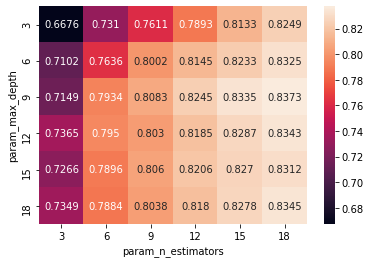

In [17]:
# XGBoost
optimal_max_depth_bow, optimal_n_estimators_bow = optimal_tree_xgb(X_train, y_train)

In [18]:
# instantiate learning model max_depth = max_depth_bow
clf = XGBClassifier(max_depth = optimal_max_depth_bow, n_estimators = optimal_n_estimators_bow)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [19]:
train_acc_bow = clf.score(X_train, y_train)
print("Train accuracy:",train_acc_bow)

Train accuracy: 0.929


In [20]:
test_acc_bow = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_bow))


The test accuracy is 86.15%


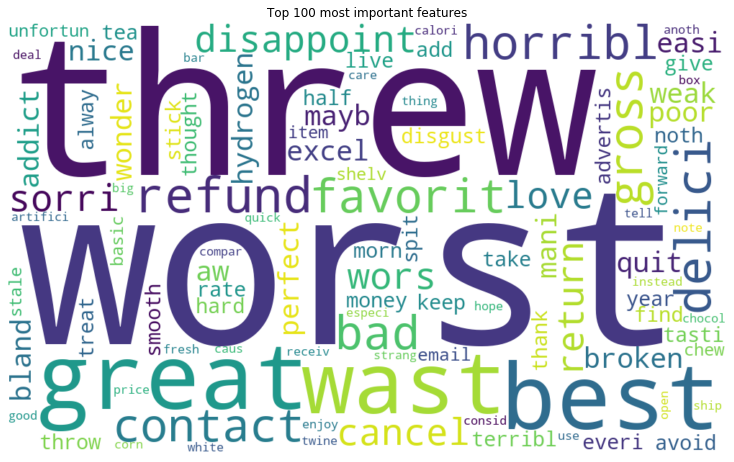

In [21]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [22]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  67,  248],
       [  15, 2670]], dtype=int64)

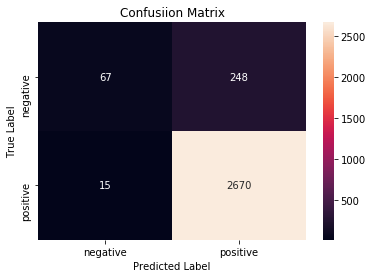

In [23]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.21      0.34       315
           1       0.92      0.99      0.95      2685

    accuracy                           0.91      3000
   macro avg       0.87      0.60      0.65      3000
weighted avg       0.90      0.91      0.89      3000




**********GridSearchCV**********


Best depth: 18

Best estimator: 15

Best Score: 0.7733114550268839


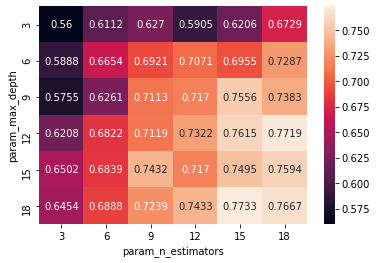

In [25]:
# Random Forest
optimal_max_depth_bow_rf, optimal_n_estimators_bow_rf = optimal_tree_rf(X_train, y_train)

In [26]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_bow_rf, n_estimators = optimal_n_estimators_bow_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [27]:
train_acc_bow_rf = clf.score(X_train, y_train)
print("Train accuracy:",train_acc_bow_rf)

Train accuracy: 0.9074285714285715


In [28]:
test_acc_bow_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_bow_rf))


The test accuracy is 78.43%


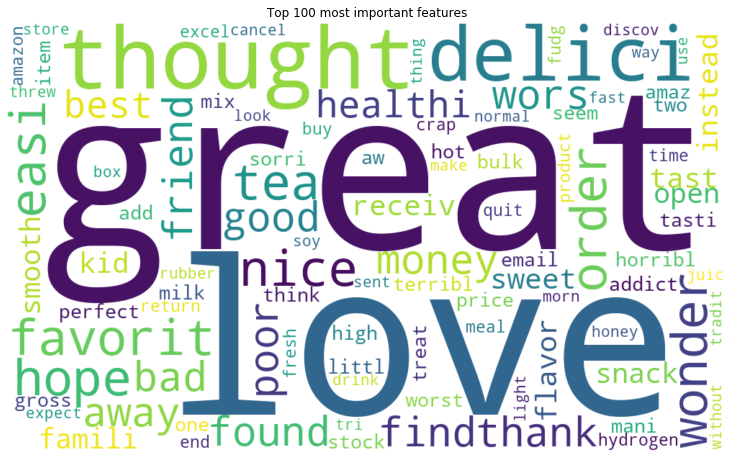

In [29]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [30]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 159,  156],
       [ 245, 2440]], dtype=int64)

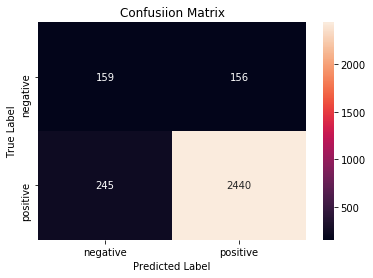

In [31]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44       315
           1       0.94      0.91      0.92      2685

    accuracy                           0.87      3000
   macro avg       0.67      0.71      0.68      3000
weighted avg       0.88      0.87      0.87      3000



# Tf-Idf

In [33]:
# data
X = final["CleanedText"]

In [34]:
# Target/class-label
y = final["Score"]

In [35]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<7000x13637 sparse matrix of type '<class 'numpy.float64'>'
	with 226839 stored elements in Compressed Sparse Row format>

In [37]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(3000, 13637)


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.8299014414665007


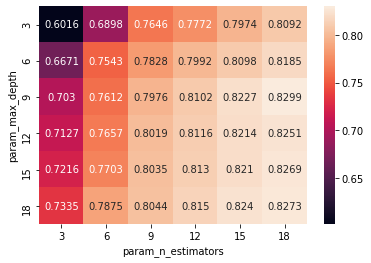

In [38]:
# XGBoost
optimal_max_depth_tfidf, optimal_n_estimators_tfidf = optimal_tree_xgb(X_train, y_train)

In [39]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_tfidf, n_estimators = optimal_n_estimators_tfidf)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [40]:
train_acc_tfidf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf))

Train accuracy 0.937000%:


In [41]:
test_acc_tfidf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the decision tree is %.2f%%' % (test_acc_tfidf))


The accuracy of the decision tree is 85.62%


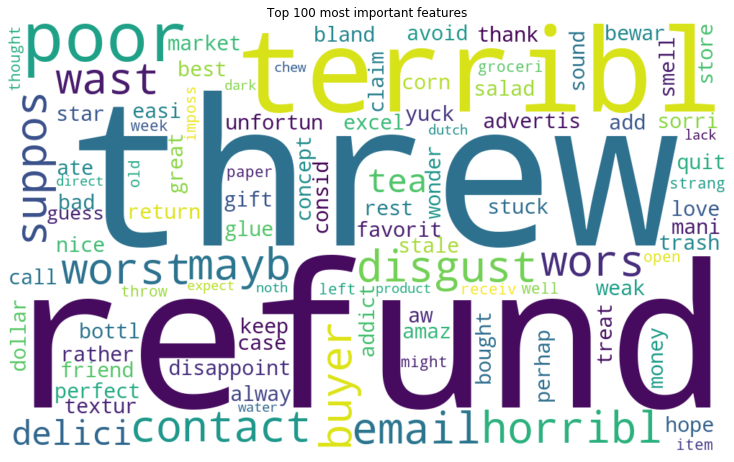

In [42]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [43]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  56,  266],
       [  17, 2661]], dtype=int64)

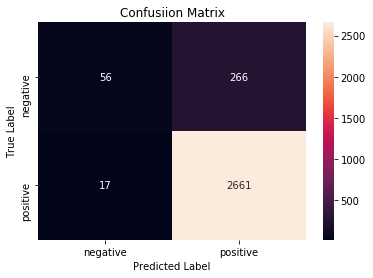

In [44]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [45]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.17      0.28       322
           1       0.91      0.99      0.95      2678

    accuracy                           0.91      3000
   macro avg       0.84      0.58      0.62      3000
weighted avg       0.89      0.91      0.88      3000




**********GridSearchCV**********


Best depth: 18

Best estimator: 18

Best Score: 0.7504959442204768


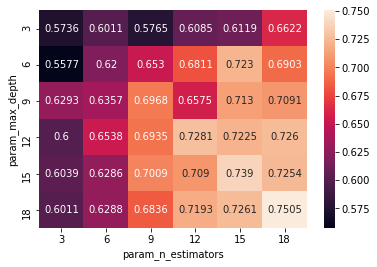

In [46]:
# Random forest
optimal_max_depth_tfidf_rf, optimal_n_estimators_tfidf_rf = optimal_tree_rf(X_train, y_train)

In [47]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_tfidf_rf, n_estimators = optimal_n_estimators_tfidf_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [48]:
train_acc_tfidf_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf_rf))

Train accuracy 0.943857%:


In [49]:
test_acc_tfidf_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidf_rf))


The test accuracy is 82.21%


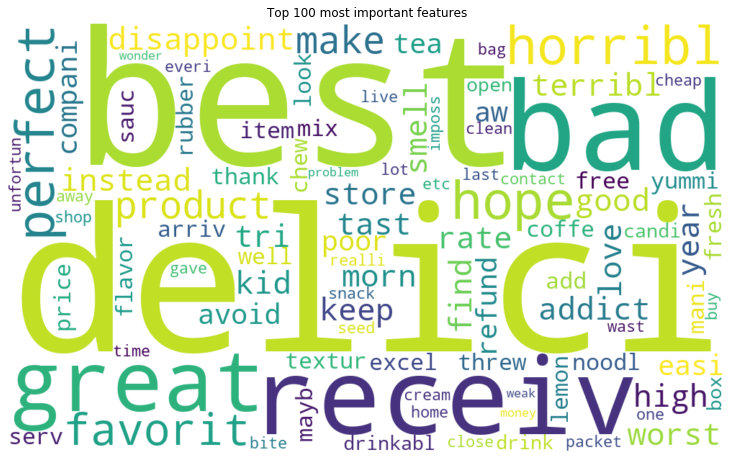

In [50]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 154,  168],
       [ 212, 2466]], dtype=int64)

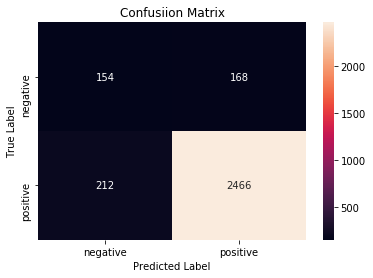

In [52]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.42      0.48      0.45       322
           1       0.94      0.92      0.93      2678

    accuracy                           0.87      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.88      0.87      0.88      3000



# Word2vec

In [54]:
# data
X = final["Text"]
y = final["Score"]

In [55]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [56]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [57]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [58]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [59]:
w2v_model_train.wv.most_similar('like')

[('prefer', 0.7782762050628662),
 ('think', 0.7132666707038879),
 ('without', 0.6974892020225525),
 ('real', 0.6941027641296387),
 ('acquire', 0.6683987975120544),
 ('maybe', 0.6618490815162659),
 ('seem', 0.6567943096160889),
 ('though', 0.6538747549057007),
 ('enjoy', 0.6528604626655579),
 ('warn', 0.6513198018074036)]

In [60]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [61]:
w2v_train.shape

(5793, 50)

In [62]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [63]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [64]:
w2v_model_test.wv.most_similar('like')

[('want', 0.9679853916168213),
 ('do', 0.9600871205329895),
 ('your', 0.9548778533935547),
 ('if', 0.9516575336456299),
 ('dont', 0.9461992979049683),
 ('not', 0.9405050277709961),
 ('can', 0.9390615224838257),
 ('make', 0.9372767806053162),
 ('urge', 0.9365132451057434),
 ('fluffy', 0.9361215233802795)]

In [65]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [66]:
w2v_test.shape

(2759, 50)

# Average word2vec

In [67]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [69]:
X_train = np.array(sent_vectors)
#X_train

In [70]:
x_test = np.array(sent_vectors_test)
#x_test


**********GridSearchCV**********


Best depth: 3

Best estimator: 18

Best Score: 0.7548945176049572


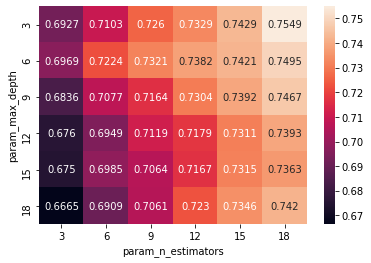

In [71]:
# XGBoost
optimal_max_depth_avgw2v, optimal_n_estimators_avgw2v = optimal_tree_xgb(X_train, y_train)

In [72]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_avgw2v, n_estimators = optimal_n_estimators_avgw2v)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [73]:
train_acc_avgw2v = clf.score(X_train, y_train)
print("Train accuracy:", train_acc_avgw2v)

Train accuracy: 0.8884285714285715


In [74]:
test_acc_avgw2v_grid = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the decision tree is %.2f%%' % (test_acc_avgw2v_grid))


The accuracy of the decision tree is 58.43%


In [75]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

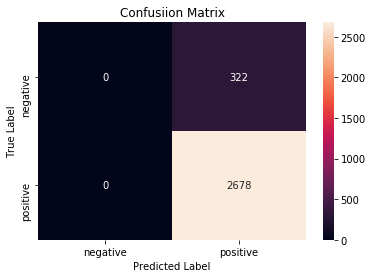

In [76]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [77]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000




**********GridSearchCV**********


Best depth: 3

Best estimator: 18

Best Score: 0.7123563429671099


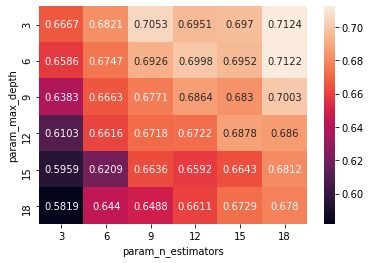

In [78]:
# Random Forest
optimal_max_depth_avgw2v_rf, optimal_n_estimators_avgw2v_rf = optimal_tree_rf(X_train, y_train)

In [79]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_avgw2v_rf, n_estimators = optimal_n_estimators_avgw2v_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [80]:
train_acc_avgw2v_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_avgw2v_rf))

Train accuracy 0.673429%:


In [81]:
test_acc_avgw2v_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_avgw2v_rf))


The test accuracy is 53.11%


In [82]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

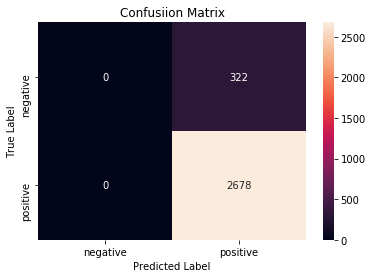

In [83]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [84]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



# TFIDF Word2Vec

In [85]:
# TF-IDF weighted Word2Vec train dataset
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [86]:
# tf idf  weigthed word2vec test dataset

tfidf_feat = tf_idf_vect.get_feature_names() #tfidf words / col name

#final tf idf is the sparse matrix with row = sentence col=word and cell val = tfidf

tfidf_sent_vectors_test = [] #the tfdif w2v row = sentence review is stored in the list

row = 0

for sent in  list_of_sent_test: #for each review or sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf idf of a word in sentence / review
            tfidf = final_tf_idf[row , tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [89]:
X_train = np.array(X_train)
x_test = np.array(x_test)


**********GridSearchCV**********


Best depth: 3

Best estimator: 18

Best Score: 0.7548945176049572


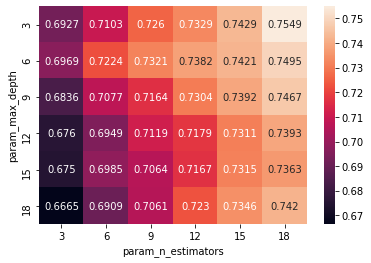

In [90]:
# XGBoost
optimal_max_depth_tfidfw2v, optimal_n_estimators_tfidfw2v = optimal_tree_xgb(X_train, y_train)

In [91]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_tfidfw2v, n_estimators = optimal_n_estimators_tfidfw2v)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [92]:
# Accuracy on train data
train_acc_tfidfw2v = clf.score(X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v)

Train accuracy 0.8884285714285715


In [93]:
test_acc_tfidfw2v = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the desicion tree is %f%%' % (test_acc_tfidfw2v))


The accuracy of the desicion tree is 58.427711%


In [94]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   0,  322],
       [   0, 2678]], dtype=int64)

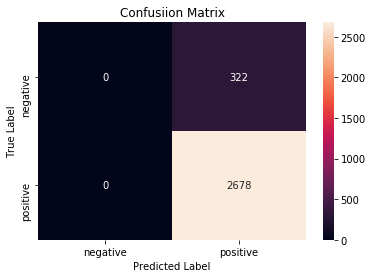

In [95]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [96]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.45      0.50      0.47      3000
weighted avg       0.80      0.89      0.84      3000



In [97]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)


**********GridSearchCV**********


Best depth: 6

Best estimator: 18

Best Score: 0.7170563629541125


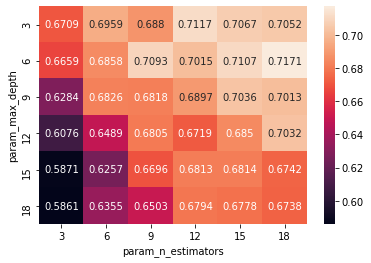

In [98]:
# Random Forest
optimal_max_depth_tfidfw2v_rf, optimal_n_estimators_tfidfw2v_rf = optimal_tree_rf(X_train, y_train)

In [99]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_tfidfw2v_rf, n_estimators = optimal_n_estimators_tfidfw2v_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [100]:
train_acc_tfidfw2v_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidfw2v_rf))

Train accuracy 0.804714%:


In [101]:
test_acc_tfidfw2v_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidfw2v_rf))


The test accuracy is 50.41%


In [102]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   5,  317],
       [  13, 2665]], dtype=int64)

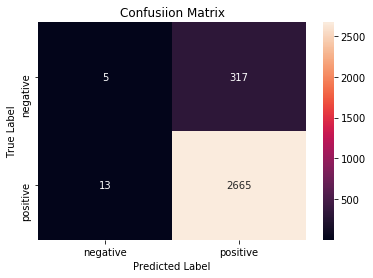

In [103]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [104]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.28      0.02      0.03       322
           1       0.89      1.00      0.94      2678

    accuracy                           0.89      3000
   macro avg       0.59      0.51      0.49      3000
weighted avg       0.83      0.89      0.84      3000



In [105]:
# model performence table
# XGBoost

models = pd.DataFrame({'Model': ['XGB with Bow', "XGB with TFIDF", "XGB with avgw2v", "XGB with TFIDFW2V"], 'Hyper Parameter(max_depth)': [optimal_max_depth_bow, optimal_max_depth_tfidf, optimal_max_depth_avgw2v, optimal_max_depth_tfidfw2v ], 'Hyper parameter(n_estimators)': [optimal_n_estimators_bow, optimal_n_estimators_tfidf, optimal_n_estimators_avgw2v, optimal_n_estimators_tfidfw2v], 'Train Error': [1-train_acc_bow, 1-train_acc_tfidf, 1-train_acc_avgw2v, 1-train_acc_tfidfw2v], 'Test Error': [100-test_acc_bow, 100-test_acc_tfidf, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v], 'Auc Score': [test_acc_bow, test_acc_tfidf, test_acc_avgw2v_grid, test_acc_tfidfw2v]}, columns = ["Model", "Hyper Parameter(max_depth)", "Hyper parameter(n_estimators)", "Train Error", "Test Error", "Auc Score"])
models.sort_values(by = 'Auc Score', ascending=False)

,Model,Hyper Parameter(max_depth),Hyper parameter(n_estimators),Train Error,Test Error,Auc Score
0,XGB with Bow,9,18,0.071000,13.846058,86.153942
1,XGB with TFIDF,9,18,0.063000,14.378314,85.621686
2,XGB with avgw2v,3,18,0.111571,41.572289,58.427711
3,XGB with TFIDFW2V,3,18,0.111571,41.572289,58.427711


In [107]:
# model performence table
# RandomForest

models = pd.DataFrame({'Model': ['RF with Bow', "RF with TFIDF", "RF with avgw2v", "RF with TFIDFW2V"], 'Hyper Parameter(max_depth)': [optimal_max_depth_bow_rf, optimal_max_depth_tfidf_rf, optimal_max_depth_avgw2v_rf, optimal_max_depth_tfidfw2v_rf ],'Hyper Parameter(n_estimators)': [optimal_max_depth_bow_rf, optimal_max_depth_tfidf_rf, optimal_max_depth_avgw2v_rf, optimal_max_depth_tfidfw2v_rf], 'Train Error': [1-train_acc_bow_rf, 1-train_acc_tfidf_rf, 1-train_acc_avgw2v_rf, 1-train_acc_tfidfw2v_rf], 'Test Error': [100-test_acc_bow_rf, 100-test_acc_tfidf_rf, 100-test_acc_avgw2v_rf, 100-test_acc_tfidfw2v_rf], 'Auc Score': [test_acc_bow_rf, test_acc_tfidf_rf, test_acc_avgw2v_rf, test_acc_tfidfw2v_rf]}, columns = ["Model", "Hyper Parameter(max_depth)", "Hyper Parameter(n_estimators)", "Train Error", "Test Error", "Auc Score"])
models.sort_values(by = 'Auc Score', ascending=False)

,Model,Hyper Parameter(max_depth),Hyper Parameter(n_estimators),Train Error,Test Error,Auc Score
1,RF with TFIDF,18,18,0.056143,17.792723,82.207277
0,RF with Bow,18,18,0.092571,21.571813,78.428187
2,RF with avgw2v,3,3,0.326571,46.891917,53.108083
3,RF with TFIDFW2V,6,6,0.195286,49.589652,50.410348
